In [1]:
import numpy as np
import scipy as sc
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

In [17]:
df = pd.read_csv('Drift_testdata.csv')
df

,Unnamed: 0,expt,baseSeq,meanEL.base,edvPred.base,representation.base,seq110,meanEL.mut,proTotal,representation.mut,...,nativeProPart,nativeMut,trajectory,trajDir,trajOpt,meanEL.delta,edvPred.delta,minAbundance,sampled_noise,edvPred.delta_noise
0,6730,NBT_S288CdU_YPD,rand1,11.559164,13.098289,0.000008,TGCATTTTTTTCACATCCTTTCAATTGGGTGGGGACGCGACGGCGC...,11.278011,733,7.029517e-06,...,NaN,False,False,NaN,NaN,0.281153,0.176662,True,0.535878,0.469172
1,6731,NBT_S288CdU_YPD,rand1,11.559164,13.098289,0.000008,TGCATTTTTTTCACATCCTTTAAATTCGGTGGGGACGCGTCGGCGC...,11.725461,452,4.556240e-06,...,NaN,False,False,NaN,NaN,-0.166297,-0.110374,True,0.390566,0.102818
2,6732,NBT_S288CdU_YPD,rand1,11.559164,13.098289,0.000008,TGCATTTTTTTCACATCCTTTCAATTGGGTGGGGACGCGACCGCGC...,11.725053,770,7.802369e-06,...,NaN,False,False,NaN,NaN,-0.165889,0.007146,True,-0.103705,-0.049462
3,6733,NBT_S288CdU_YPD,rand10,10.979950,11.400604,0.000003,TGCATTTTTTTCACATCTTTTCCGTGCAACGGCCTAGAGGACAGTC...,9.008385,40,5.065560e-07,...,NaN,False,False,NaN,NaN,1.971565,1.184752,False,-1.718233,0.246850
4,6734,NBT_S288CdU_YPD,rand10,10.979950,11.400604,0.000003,TGCATTTTTTTCACATCTTTTCCGTGCAACGGCCTAGACGACAGTC...,10.695459,320,3.361639e-06,...,NaN,False,False,NaN,NaN,0.284491,-0.233469,True,0.287908,-0.076314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2978,9708,NBT_S288CdU_YPD,rand998,12.830828,13.765704,0.000006,TGCATTTTTTTCACATCTCGCTAGCCGCAGGTATGAATATCGTAAC...,12.134682,364,3.888808e-06,...,NaN,False,False,NaN,NaN,0.696146,0.472890,True,0.097384,0.526048
2979,9709,NBT_S288CdU_YPD,rand998,12.830828,13.765704,0.000006,TGCATTTTTTTCACATCTCGCTAGCCGCAGGTACGAGTATCGTAAC...,13.562228,332,5.462700e-06,...,NaN,False,False,NaN,NaN,-0.731401,-0.851653,True,-0.354107,-1.044943
2980,9710,NBT_S288CdU_YPD,rand999,13.563372,13.245996,0.000003,TGCATTTTTTTCACATCGGAACGTTAACATCAATCCGGTCACCACG...,10.788450,336,3.257878e-06,...,NaN,False,False,NaN,NaN,2.774922,2.188955,True,-0.038163,2.168123
2981,9711,NBT_S288CdU_YPD,rand999,13.563372,13.245996,0.000003,TGCATTTTTTTCACATCGGAACGTTAATATCCATCCGGTCACCACG...,12.423164,163,1.894307e-06,...,NaN,False,False,NaN,NaN,1.140208,0.034277,True,-0.203094,-0.076582


In [31]:
df.columns

Index(['Unnamed: 0', 'expt', 'baseSeq', 'meanEL.base', 'edvPred.base',
       'representation.base', 'seq110', 'meanEL.mut', 'proTotal',
       'representation.mut', 'sdEL', 'relativeSD', 'sdScale', 'origID',
       'edvPred.mut', 'tiling', 'motif', 'positionSpike', 'isRC', 'designed',
       'designedCond', 'designedDir', 'designedID', 'designedSNPDEV',
       'designedSNPDEVMin', 'mutDesc', 'ED', 'gini', 'HQ', 'rand', 'randMut',
       'native', 'nativeGene', 'nativeProPart', 'nativeMut', 'trajectory',
       'trajDir', 'trajOpt', 'meanEL.delta', 'edvPred.delta', 'minAbundance',
       'sampled_noise', 'edvPred.delta_noise'],
      dtype='object')

2.086966050428829
1.4506111869871416
0.7430937461483639


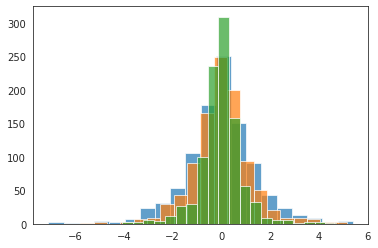

In [33]:
plt.hist(df.loc[df.ED == 3]['meanEL.delta'], bins=20, alpha=0.7);
plt.hist(df.loc[df.ED == 2]['meanEL.delta'], bins=20, alpha=0.7);
plt.hist(df.loc[df.ED == 1]['meanEL.delta'], bins=20, alpha=0.7);
print(np.var(df.loc[df.ED == 3]['meanEL.delta']))
print(np.var(df.loc[df.ED == 2]['meanEL.delta']))
print(np.var(df.loc[df.ED == 1]['meanEL.delta']))

2.827302959300305
1.8915167165857898
0.8636227021458265


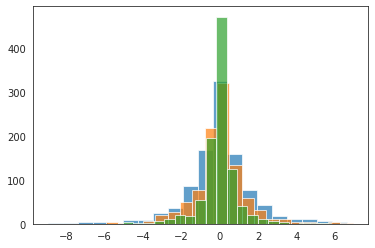

In [32]:
plt.hist(df.loc[df.ED == 3]['edvPred.delta'], bins=20, alpha=0.7);
plt.hist(df.loc[df.ED == 2]['edvPred.delta'], bins=20, alpha=0.7);
plt.hist(df.loc[df.ED == 1]['edvPred.delta'], bins=20, alpha=0.7);
print(np.var(df.loc[df.ED == 3]['edvPred.delta']))
print(np.var(df.loc[df.ED == 2]['edvPred.delta']))
print(np.var(df.loc[df.ED == 1]['edvPred.delta']))